In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/reviews-tasm/sample_tasm_movies.csv
/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


# Imports

In [3]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim import corpora
from gensim.models import LdaModel
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.metrics import precision_score, recall_score, f1_score

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Global variables
stop_words = set(stopwords.words('english'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Setup complete. Using device:", device)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Setup complete. Using device: cuda


# Loading and Preprocessing Data

In [4]:
# Load dataset
df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
# df = df.sample(1000, random_state=42) 

# Preprocessing function
def preprocess_review(review):
    review = review.replace("br", "").lower()  # Remove "br" noise
    sentences = sent_tokenize(review)
    cleaned_sentences = []
    for sent in sentences:
        words = word_tokenize(sent)
        words = [word for word in words if word.isalnum() and word not in stop_words]
        if words:
            cleaned_sentences.append(" ".join(words))
    return cleaned_sentences

# Apply preprocessing
df['cleaned_sentences'] = df['review'].apply(preprocess_review)

# Verify
print("Preprocessing done. Sample:")
print(df[['review', 'cleaned_sentences']].head())

Preprocessing done. Sample:
                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                   cleaned_sentences  
0  [one reviewers mentioned watching 1 oz episode...  
1  [wonderful little production, filming techniqu...  
2  [thought wonderful way spend time hot summer w...  
3  [basically family little boy jake thinks zombi...  
4  [petter mattei love time money visually stunni...  


# Topic Modeling with LDA

In [5]:
# Prepare data for LDA
all_sentences = [sent for sublist in df['cleaned_sentences'] for sent in sublist if sent]
tokenized_sentences = [sent.split() for sent in all_sentences]
dictionary = corpora.Dictionary(tokenized_sentences)
corpus = [dictionary.doc2bow(text) for text in tokenized_sentences]

# Train LDA with 5 topics
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=10, random_state=42)

# Display topics
print("LDA Topics:")
topics = lda_model.print_topics(num_words=10)
for idx, topic in topics:
    print(f"Topic {idx}: {topic}")

# Save LDA models
lda_model.save("/kaggle/working/lda_model.gensim")
dictionary.save("/kaggle/working/dictionary.gensim")

LDA Topics:
Topic 0: 0.049*"movie" + 0.022*"one" + 0.017*"film" + 0.016*"see" + 0.016*"movies" + 0.016*"like" + 0.015*"would" + 0.011*"even" + 0.009*"watch" + 0.009*"good"
Topic 1: 0.025*"film" + 0.018*"movie" + 0.015*"characters" + 0.013*"story" + 0.013*"plot" + 0.012*"scenes" + 0.010*"good" + 0.010*"well" + 0.009*"acting" + 0.008*"even"
Topic 2: 0.010*"trek" + 0.009*"rental" + 0.009*"expects" + 0.009*"coburn" + 0.009*"eed" + 0.009*"one" + 0.009*"film" + 0.008*"lethargic" + 0.005*"art" + 0.005*"star"
Topic 3: 0.015*"one" + 0.009*"story" + 0.007*"man" + 0.007*"life" + 0.006*"revenge" + 0.006*"fellow" + 0.006*"nasty" + 0.006*"goofy" + 0.006*"implausible" + 0.006*"mccoy"
Topic 4: 0.013*"michael" + 0.010*"gives" + 0.010*"sheriff" + 0.010*"escaped" + 0.009*"technological" + 0.009*"symbolizes" + 0.009*"complacency" + 0.009*"role" + 0.009*"bowling" + 0.007*"performance"


# Aspect Refinement

In [6]:
# Define aspect keywords
aspect_keywords = {
    "acting": ["actor", "actress", "performance", "cast", "role", "played", "plays"],
    "plot": ["story", "plot", "narrative", "script", "ending"],
    "cinematography": ["visual", "cinematography", "camera", "shot", "scene", "scenes", "look"],
    "soundtrack": ["music", "sound", "score", "soundtrack", "audio"],
    "direction": ["director", "direction", "paced", "style", "vision"],
    "overall": ["movie", "film", "good", "bad", "great"]
}

# Topic-to-aspect mapping based on LDA output
topic_to_aspect = {
    0: "general_viewing_experience",
    1: "story_and_performance",
    2: "production_quality",
    3: "narrative_tone",
    4: "character_roles_and_execution",
    -1: "unknown"
}

# Function to get dominant topic
def get_dominant_topic(sentence):
    if not sentence:
        return -1
    bow = dictionary.doc2bow(sentence.split())
    topics = lda_model[bow]
    return max(topics, key=lambda x: x[1])[0] if topics else -1

# Assign dominant topics to each sentence in the DataFrame
df['dominant_topic'] = df['cleaned_sentences'].apply(lambda x: [get_dominant_topic(sent) for sent in x])

# Verify
print("Step 4 complete. Sample dominant topics:")
print(df[['cleaned_sentences', 'dominant_topic']].head())

Step 4 complete. Sample dominant topics:
                                   cleaned_sentences  \
0  [one reviewers mentioned watching 1 oz episode...   
1  [wonderful little production, filming techniqu...   
2  [thought wonderful way spend time hot summer w...   
3  [basically family little boy jake thinks zombi...   
4  [petter mattei love time money visually stunni...   

                   dominant_topic  
0  [0, 0, 3, 3, 4, 2, 3, 4, 0, 2]  
1           [1, 1, 0, 1, 1, 3, 1]  
2                    [0, 1, 1, 0]  
3              [3, 1, 3, 3, 0, 3]  
4     [0, 3, 3, 1, 0, 1, 0, 3, 4]  


In [7]:
df.head()

,review,sentiment,cleaned_sentences,dominant_topic
0,One of the other reviewers has mentioned that ...,positive,[one reviewers mentioned watching 1 oz episode...,"[0, 0, 3, 3, 4, 2, 3, 4, 0, 2]"
1,A wonderful little production. <br /><br />The...,positive,"[wonderful little production, filming techniqu...","[1, 1, 0, 1, 1, 3, 1]"
2,I thought this was a wonderful way to spend ti...,positive,[thought wonderful way spend time hot summer w...,"[0, 1, 1, 0]"
3,Basically there's a family where a little boy ...,negative,[basically family little boy jake thinks zombi...,"[3, 1, 3, 3, 0, 3]"
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,[petter mattei love time money visually stunni...,"[0, 3, 3, 1, 0, 1, 0, 3, 4]"


# Sentiment Analysis using BERT

In [8]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import shutil
import os

# Clear any cached files to force fresh download
cache_dir = "/kaggle/working/transformers_cache"
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)
    print("Cleared cache to force fresh download.")

# Load binary BERT model
model_name = "textattack/bert-base-uncased-SST-2"
try:
    tokenizer = BertTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
    model = BertForSequenceClassification.from_pretrained(model_name, cache_dir=cache_dir)
    model.to(device)
    print("Model and tokenizer loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# Test the model on a sample sentence
sample_sentence = "The acting was great."
inputs = tokenizer(sample_sentence, return_tensors="pt", truncation=True, padding=True, max_length=128)
inputs = {key: val.to(device) for key, val in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
logits = outputs.logits
sentiment_id = torch.argmax(logits, dim=1).item()
sentiment = "positive" if sentiment_id == 1 else "negative"
print(f"Test: '{sample_sentence}' -> Sentiment: {sentiment}")

# Save BERT models
model.save_pretrained("/kaggle/working/bert_model")
tokenizer.save_pretrained("/kaggle/working/bert_tokenizer")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Model and tokenizer loaded successfully.
Test: 'The acting was great.' -> Sentiment: positive


('/kaggle/working/bert_tokenizer/tokenizer_config.json',
 '/kaggle/working/bert_tokenizer/special_tokens_map.json',
 '/kaggle/working/bert_tokenizer/vocab.txt',
 '/kaggle/working/bert_tokenizer/added_tokens.json')

# Combine Aspects and Sentiments

In [9]:
# Function to analyze a review and return aspect-sentiment pairs
def analyze_review(review):
    # Preprocess the review
    sentences = sent_tokenize(review.lower().replace("br", ""))
    cleaned_sentences = []
    for sent in sentences:
        words = word_tokenize(sent)
        words = [word for word in words if word.isalnum() and word not in stop_words]
        if words:
            cleaned_sentences.append(" ".join(words))
    
    # Extract aspects and corresponding clauses
    def extract_aspects_and_clauses(sentence):
        clauses = re.split(r'\b(but|and|,)\b', sentence)
        clauses = [clause.strip() for clause in clauses if clause.strip() and clause not in ["but", "and", ","]]
        aspects = []
        clause_texts = []
        for clause in clauses:
            found_aspects = []
            for aspect, keywords in aspect_keywords.items():
                if any(kw in clause for kw in keywords):
                    found_aspects.append(aspect)
            if found_aspects:
                aspects.extend(found_aspects)
                clause_texts.append(clause)
        # Fallback to LDA if no keywords match
        if not aspects:
            bow = dictionary.doc2bow(sentence.split())
            topics = lda_model[bow]
            if topics:
                topic_id = max(topics, key=lambda x: x[1])[0]
                aspects.append(topic_to_aspect.get(topic_id, "unknown"))
                clause_texts.append(sentence)
        return aspects, clause_texts if clause_texts else [sentence]
    
    # Predict sentiment using BERT
    def get_sentiment(text):
        if not text:
            return "positive"  # Default for empty text
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
        inputs = {key: val.to(device) for key, val in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        sentiment_id = torch.argmax(logits, dim=1).item()
        return "positive" if sentiment_id == 1 else "negative"
    
    # Combine aspects and sentiments
    all_aspects = []
    all_sentiments = []
    for sent in cleaned_sentences:
        aspects, clauses = extract_aspects_and_clauses(sent)
        if len(aspects) > 1 and len(clauses) >= len(aspects):
            sentiments = [get_sentiment(clause) for clause in clauses[:len(aspects)]]
        else:
            sentiments = [get_sentiment(sent)] * len(aspects)  # Use full sentence if clauses don’t align
        all_aspects.extend(aspects)
        all_sentiments.extend(sentiments[:len(aspects)])
    
    return list(zip(all_aspects, all_sentiments))

# Apply to the DataFrame
df['aspect_sentiment'] = df['review'].apply(analyze_review)

# Verify
print("Step 6 complete. Sample aspect-sentiment pairs:")
print(df[['cleaned_sentences', 'aspect_sentiment']].head())

Step 6 complete. Sample aspect-sentiment pairs:
                                   cleaned_sentences  \
0  [one reviewers mentioned watching 1 oz episode...   
1  [wonderful little production, filming techniqu...   
2  [thought wonderful way spend time hot summer w...   
3  [basically family little boy jake thinks zombi...   
4  [petter mattei love time money visually stunni...   

                                    aspect_sentiment  
0  [(general_viewing_experience, positive), (cine...  
1  [(story_and_performance, positive), (overall, ...  
2  [(general_viewing_experience, positive), (plot...  
3  [(overall, negative), (overall, positive), (na...  
4  [(cinematography, positive), (overall, positiv...  


# Evaluation Metrics

In [10]:
# Heuristic Agreement
def evaluate_system(df, system_name="Current System"):
    def aggregate_sentiment(aspect_sentiment_pairs):
        if not aspect_sentiment_pairs:
            return "positive"  # Default if no aspects
        sentiments = [pair[1] for pair in aspect_sentiment_pairs]
        sentiment_counts = Counter(sentiments)
        return max(sentiment_counts.items(), key=lambda x: x[1])[0]  # Majority vote
    
    df['predicted_overall_sentiment'] = df['aspect_sentiment'].apply(aggregate_sentiment)
    agreement = (df['predicted_overall_sentiment'] == df['sentiment']).mean()
    print(f"\nEvaluation for {system_name}:")
    print(f"Heuristic Agreement with Overall Sentiment: {agreement:.2%}")
    print("Breakdown:")
    cross_tab = pd.crosstab(df['sentiment'], df['predicted_overall_sentiment'], rownames=['Actual'], colnames=['Predicted'])
    print(cross_tab)

# Run evaluation
evaluate_system(df, "Fresh System (5 Topics)")

# Manual Validation Sample
sample_df = df[['review', 'aspect_sentiment']].sample(5, random_state=42)  # Small sample for now
print("\nManual Validation Sample (Label these manually if desired):")
for idx, row in sample_df.iterrows():
    print(f"\nReview {idx}: {row['review'][:200]}...")  # Truncate for readability
    print(f"Predicted Aspect-Sentiment: {row['aspect_sentiment']}")
    print("True Aspect-Sentiment: [e.g., [('acting', 'positive'), ('plot', 'negative')]]")


Evaluation for Fresh System (5 Topics):
Heuristic Agreement with Overall Sentiment: 80.96%
Breakdown:
Predicted  negative  positive
Actual                       
negative      20566      4434
positive       5087     19913

Manual Validation Sample (Label these manually if desired):

Review 33553: I really liked this Summerslam due to the look of the arena, the curtains and just the look overall was interesting to me for some reason. Anyways, this could have been one of the best Summerslam's ev...
Predicted Aspect-Sentiment: [('cinematography', 'positive'), ('general_viewing_experience', 'positive'), ('story_and_performance', 'negative'), ('plot', 'negative'), ('story_and_performance', 'negative')]
True Aspect-Sentiment: [e.g., [('acting', 'positive'), ('plot', 'negative')]]

Review 9427: Not many television shows appeal to quite as many different kinds of fans like Farscape does...I know youngsters and 30/40+ years old;fans both Male and Female in as many different countries as you ca

# Visualization

<Figure size 1200x600 with 0 Axes>

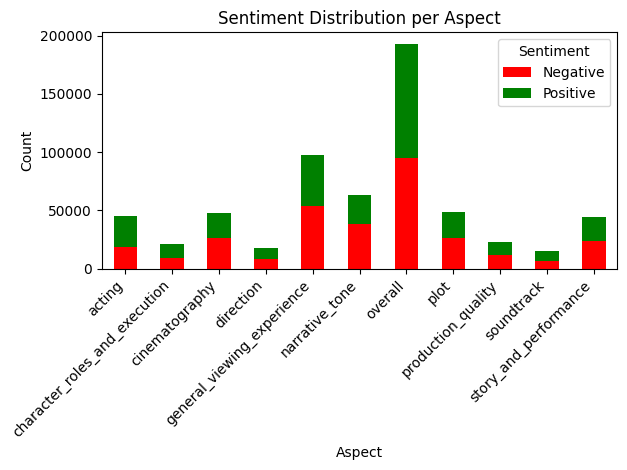


Sentiment Counts per Aspect:
sentiment                      negative  positive
aspect                                           
acting                            18418     26697
character_roles_and_execution      9022     12381
cinematography                    26315     21293
direction                          8572      9228
general_viewing_experience        53792     43691
narrative_tone                    38233     24557
overall                           94687     98483
plot                              26598     22422
production_quality                11515     11181
soundtrack                         6697      8473
story_and_performance             23624     20253


In [14]:
# Explode the aspect_sentiment column into a flat DataFrame
exploded_df = df['aspect_sentiment'].explode().dropna()
aspect_sentiment_df = pd.DataFrame(exploded_df.tolist(), index=exploded_df.index, columns=['aspect', 'sentiment'])

# Count sentiments per aspect
sentiment_counts = aspect_sentiment_df.groupby(['aspect', 'sentiment']).size().unstack(fill_value=0)

# Plot stacked bar chart
plt.figure(figsize=(12, 6))
sentiment_counts.plot(kind='bar', stacked=True, color=['red', 'green'])
plt.title("Sentiment Distribution per Aspect")
plt.xlabel("Aspect")
plt.ylabel("Count")
plt.legend(title="Sentiment", labels=['Negative', 'Positive'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Display raw counts for reference
print("\nSentiment Counts per Aspect:")
print(sentiment_counts)

# Interactive Tool

Aspect-Based Sentiment Analysis Tool:

Input Review: A vibrant, quirky masterpiece with charming chaos and impeccable humor. The visual is also not bad.
Analysis:
- Sentence: 'viant quirky masterpiece charming chaos impeccable humor' | Aspect: production_quality | Sentiment: positive
- Sentence: 'visual also bad' | Aspect: cinematography | Sentiment: negative


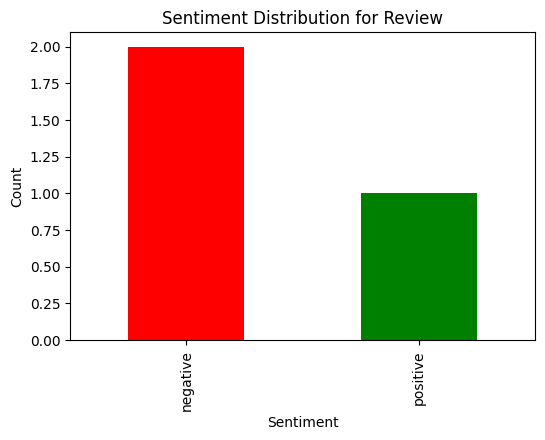


Input Review: Despite a promising premise, the film falls flat due to poorly developed characters and a disjointed storyline. The pacing is inconsistent, making it hard to stay engaged, and the dialogue lacks depth. Overall, a disappointing execution of what could have been a compelling narrative
Analysis:
- Sentence: 'despite promising premise film falls flat due poorly developed characters disjointed storyline' | Aspect: plot | Sentiment: negative
- Sentence: 'pacing inconsistent making hard stay engaged dialogue lacks depth' | Aspect: overall | Sentiment: negative
- Sentence: 'overall disappointing execution could compelling narrative' | Aspect: story_and_performance | Sentiment: negative


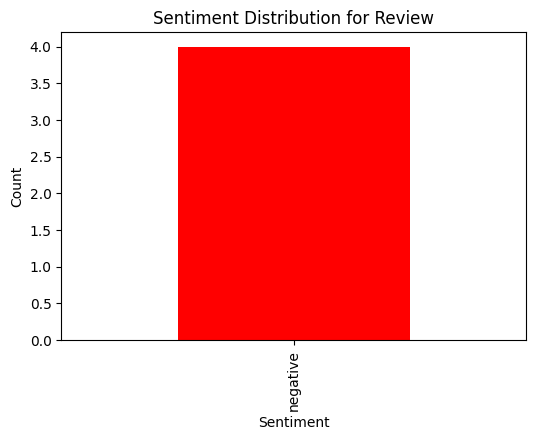


Input Review: Some scenes are captivating. But the overall story feels uneven and fails to fully engage.
Analysis:
- Sentence: 'scenes captivating' | Aspect: cinematography | Sentiment: positive
- Sentence: 'overall story feels uneven fails fully engage' | Aspect: plot | Sentiment: negative


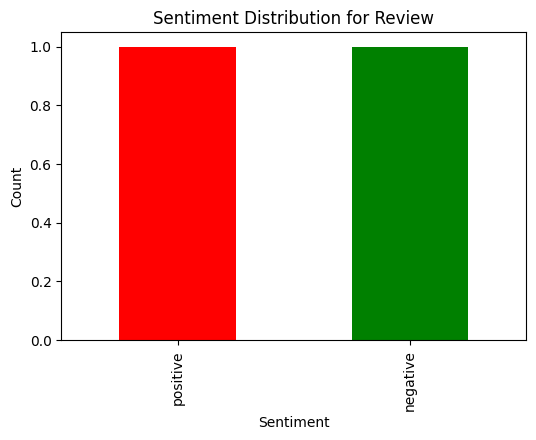

In [18]:
# Interactive analysis function
def display_analysis(review):
    sentences = sent_tokenize(review.lower().replace("br", ""))
    cleaned_sentences = []
    for sent in sentences:
        words = word_tokenize(sent)
        words = [word for word in words if word.isalnum() and word not in stop_words]
        if words:
            cleaned_sentences.append(" ".join(words))
    
    # aspect_keywords
    aspect_keywords_local = {
        "acting": ["actor", "actress", "performance", "cast", "role", "played", "plays", "acting"],
        "plot": ["story", "plot", "narrative", "script", "ending"],
        "cinematography": ["visual", "cinematography", "camera", "shot", "scene", "scenes", "look"],
        "soundtrack": ["music", "sound", "score", "soundtrack", "audio", "songs"],
        "direction": ["director", "direction", "paced", "style", "vision"],
        "overall": ["movie", "film", "good", "bad", "great", "audience"]
    }
    
    def extract_aspects_and_clauses(sentence):
        clauses = re.split(r'\b(but|and|,)\b', sentence)
        clauses = [clause.strip() for clause in clauses if clause.strip() and clause not in ["but", "and", ","]]
        aspects = []
        clause_texts = []
        for clause in clauses:
            found_aspects = []
            for aspect, keywords in aspect_keywords_local.items():
                if any(kw in clause for kw in keywords):
                    found_aspects.append(aspect)
            if found_aspects:
                aspects.extend(found_aspects)
                clause_texts.append(clause)
        if not aspects:
            bow = dictionary.doc2bow(sentence.split())
            topics = lda_model[bow]
            if topics:
                topic_id = max(topics, key=lambda x: x[1])[0]
                aspects.append(topic_to_aspect.get(topic_id, "unknown"))
                clause_texts.append(sentence)
        return aspects, clause_texts if clause_texts else [sentence]
    
    def get_sentiment(text):
        if not text:
            return "positive"
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
        inputs = {key: val.to(device) for key, val in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        sentiment_id = torch.argmax(logits, dim=1).item()
        return "positive" if sentiment_id == 1 else "negative"
    
    all_aspects = []
    all_sentiments = []
    for sent in cleaned_sentences:
        aspects, clauses = extract_aspects_and_clauses(sent)
        if len(aspects) > 1 and len(clauses) >= len(aspects):
            sentiments = [get_sentiment(clause) for clause in clauses[:len(aspects)]]
        else:
            sentiments = [get_sentiment(sent)] * len(aspects)
        all_aspects.extend(aspects)
        all_sentiments.extend(sentiments[:len(aspects)])
    
    aspect_sentiment_pairs = list(zip(all_aspects, all_sentiments))
    
    # Display results
    print(f"\nInput Review: {review}")
    print("Analysis:")
    for sent, (aspect, sentiment) in zip(cleaned_sentences, aspect_sentiment_pairs):
        print(f"- Sentence: '{sent}' | Aspect: {aspect} | Sentiment: {sentiment}")
    
    if aspect_sentiment_pairs:
        aspects, sentiments = zip(*aspect_sentiment_pairs)
        sentiment_counts = pd.Series(sentiments).value_counts()
        plt.figure(figsize=(6, 4))
        sentiment_counts.plot(kind='bar', color=['red', 'green'])
        plt.title("Sentiment Distribution for Review")
        plt.xlabel("Sentiment")
        plt.ylabel("Count")
        plt.show()

# Testing
print("Aspect-Based Sentiment Analysis Tool:")
test_reviews = [
    "A vibrant, quirky masterpiece with charming chaos and impeccable humor. The visual is also not bad.",
    "Despite a promising premise, the film falls flat due to poorly developed characters and a disjointed storyline. The pacing is inconsistent, making it hard to stay engaged, and the dialogue lacks depth. Overall, a disappointing execution of what could have been a compelling narrative",
    "Some scenes are captivating. But the overall story feels uneven and fails to fully engage."
]

for review in test_reviews:
    display_analysis(review)

In [16]:
df.head()

,review,sentiment,cleaned_sentences,dominant_topic,aspect_sentiment,predicted_overall_sentiment
0,One of the other reviewers has mentioned that ...,positive,[one reviewers mentioned watching 1 oz episode...,"[0, 0, 3, 3, 4, 2, 3, 4, 0, 2]","[(general_viewing_experience, positive), (cine...",negative
1,A wonderful little production. <br /><br />The...,positive,"[wonderful little production, filming techniqu...","[1, 1, 0, 1, 1, 3, 1]","[(story_and_performance, positive), (overall, ...",positive
2,I thought this was a wonderful way to spend ti...,positive,[thought wonderful way spend time hot summer w...,"[0, 1, 1, 0]","[(general_viewing_experience, positive), (plot...",positive
3,Basically there's a family where a little boy ...,negative,[basically family little boy jake thinks zombi...,"[3, 1, 3, 3, 0, 3]","[(overall, negative), (overall, positive), (na...",negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,[petter mattei love time money visually stunni...,"[0, 3, 3, 1, 0, 1, 0, 3, 4]","[(cinematography, positive), (overall, positiv...",positive


In [19]:
# Test the model on a sample sentence
sample_sentence = "The acting was not great."
inputs = tokenizer(sample_sentence, return_tensors="pt", truncation=True, padding=True, max_length=128)
inputs = {key: val.to(device) for key, val in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
logits = outputs.logits
sentiment_id = torch.argmax(logits, dim=1).item()
sentiment = "positive" if sentiment_id == 1 else "negative"
print(f"Test: '{sample_sentence}' -> Sentiment: {sentiment}")

Test: 'The acting was not great.' -> Sentiment: negative
